In [12]:
import os
import igl
import subprocess
import numpy as np 
import shapeworks as sw
import meshplot as mp
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.decomposition import PCA

from ipywidgets import interact, widgets

In [53]:
def warp_mesh(mesh, particles):
    warper = sw.MeshWarper()
    warper.generateWarp(mesh, particles.reshape(-1,3))
    warped_mesh = warper.buildMesh(particles.reshape(-1,3))
    
    return warped_mesh

## Load particles

In [49]:
particle_list = []

for particles_path in tqdm(sorted(glob("shape_model/hippocampus_particles/*left_local.particles"))):
    particles = sw.ParticleSystem([particles_path]).ShapeAsPointSet(0)
    particle_list.append(particles.flatten())

original_particles = np.array(particle_list)

100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 258.65it/s]


## Load meshes

In [42]:
mesh_list = []

for mesh_path in tqdm(sorted(glob("groomed/meshes/data/*left.vtk"))):
    mesh = sw.Mesh(mesh_path)
    mesh_list.append(mesh)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.24it/s]


## Fit PCA

In [43]:
pca = PCA(n_components=16)
pca.fit(particle_array)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

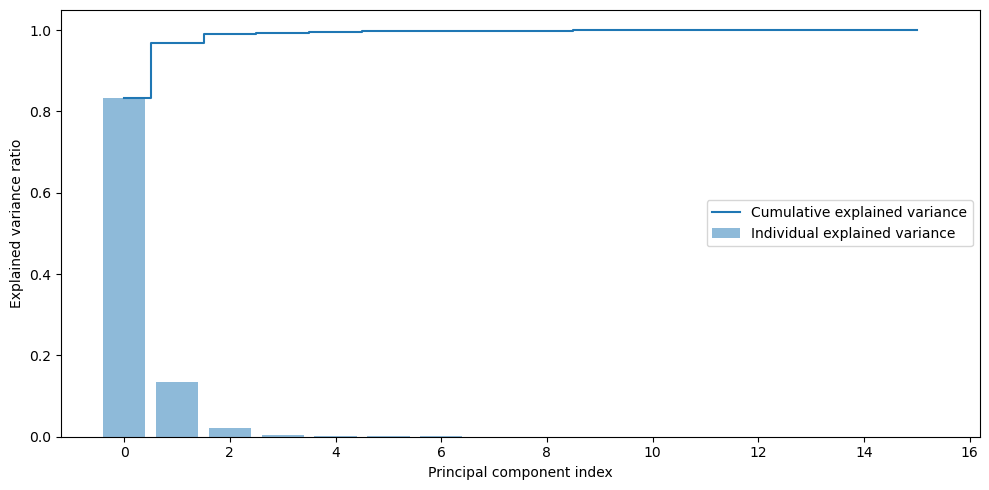

In [44]:
plt.figure(figsize=(10,5))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.tight_layout()
plt.show()

## Original particle reconstruction

In [64]:
recon_dir = 'orig_particle_reconstruction/'
if not os.path.exists(recon_dir):
    os.makedirs(recon_dir)

In [67]:
meshes = sorted(glob("groomed/meshes/data/*left.vtk"))
particles = sorted(glob("shape_model/hippocampus_particles/*left_local.particles"))

for i, mesh_path in tqdm(enumerate(meshes)):
    mesh_name = mesh_path.split("\\")[-1].replace('vtk', "")
    mesh = sw.Mesh(mesh_path)
    particle = sw.ParticleSystem([particles[i]]).ShapeAsPointSet(0)
    mesh = warp_mesh(mesh, particle)
    mesh.write(f"{recon_dir}{mesh_name}.ply")
                   

100it [02:37,  1.58s/it]


In [70]:
meshes = sorted(glob("orig_particle_reconstruction/*.ply"))

vertices, faces = igl.read_triangle_mesh(meshes[0])
p = mp.plot(vertices, faces)

@interact(i=widgets.IntSlider(value=0, min=0, max=len(meshes), step=1))
def plot_surface_reconstruction(i):
    vertices, faces = igl.read_triangle_mesh(meshes[i])
    p.update_object(vertices=vertices, faces=faces)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(89.228000…

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

## PCA particle reconstruction

In [75]:
pca_recon_dir = 'pca_particle_reconstruction/'
if not os.path.exists(pca_recon_dir):
    os.makedirs(pca_recon_dir)

In [76]:
pca_latent = pca.transform(original_particles)
recon_particles = pca.inverse_transform(pca_latent)
recon_particles = recon_particles.reshape(pca_latent.shape[0], -1)

In [78]:
meshes = sorted(glob("groomed/meshes/data/*left.vtk"))
particles = sorted(glob("shape_model/hippocampus_particles/*left_local.particles"))

for i, mesh_path in tqdm(enumerate(meshes)):
    mesh_name = mesh_path.split("\\")[-1].replace('vtk', "")
    mesh = sw.Mesh(mesh_path)
    mesh = warp_mesh(mesh, recon_particles[i])
    mesh.write(f"{pca_recon_dir}{mesh_name}.ply")

100it [02:35,  1.55s/it]


In [79]:
meshes = sorted(glob("pca_particle_reconstruction/*.ply"))

vertices, faces = igl.read_triangle_mesh(meshes[0])
p = mp.plot(vertices, faces)

@interact(i=widgets.IntSlider(value=0, min=0, max=len(meshes), step=1))
def plot_surface_reconstruction(i):
    vertices, faces = igl.read_triangle_mesh(meshes[i])
    p.update_object(vertices=vertices, faces=faces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(89.160797…

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

## Reconstruction difference

In [82]:
orig_meshes = sorted(glob("orig_particle_reconstruction/*.ply"))
recon_meshes = sorted(glob("pca_particle_reconstruction/*.ply"))

In [85]:
vertices_o, faces_o = igl.read_triangle_mesh(orig_meshes[0])
vertices_r, faces_r = igl.read_triangle_mesh(recon_meshes[0])

diff = vertices_o - vertices_r
dist = np.linalg.norm(diff, axis=1)

ValueError: operands could not be broadcast together with shapes (4824,3) (4821,3) 